## YouTube Comments Spam Classification

In this notebook, we will build a spam comment classification model to automatically filter spams in YouTube comment. The dataset is available here: http://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection

In [1]:
# Imports

# Importing data analysis packages
import pandas as pd
import numpy as np
import glob
import bs4
from wordcloud import wordcloud
import matplotlib.pyplot as plt
import warnings

# Importing natural language processing packages
import re
import emoji
import string
from nltk.corpus import stopwords
from ekphrasis.dicts.emoticons import emoticons


# Importing model selection and feature extraction packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Importing machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    confusion_matrix
)
from mlxtend.plotting import plot_confusion_matrix

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Deifining Global Variables

NUMERIC_PATTERN = '\w*\d\w*'
HTTP_URL_PATTERN = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
URL_PATTERN = '[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
HTML_APOSTROPHE_PATTERN = '&#39'

COLUMN_CONTENT = 'CONTENT'

### Data Import

In [4]:
# Reading all the csv files and merging them into a single dataframe

def get_dataset(path):
    '''
    A helper method which merges the dataset into a single dataframe.

    Parameters
    ----------
    path : str
        Path of the data folder from which the separate files can be accessed

    Returns
    -------
    data : pandas.DataFrame
        Merged dataset.

    '''
    files = glob.glob(path + '/*.csv')
    data = list()

    for file in files:
        data.append(pd.read_csv(file))

    return pd.concat(data)

In [5]:
youtube_data = get_dataset('./data')

**It is important to see the actual data. Here are the first ten rows**

In [6]:
# First 10 rows of the dataset
youtube_data.head(10)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13uwn2heqndtr5g304ccv5j5kqqzxjadmc0k,Corey Wilson,2015-05-28T21:39:52.376000,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,z124jvczaz3dxhnbc04cffk43oiugj25yzo0k,Epic Gaming,2015-05-28T20:07:20.610000,wierd but funny﻿,0
2,z13tczjy5xj0vjmu5231unho1ofey5zdk,LaS Music,2015-05-28T19:23:35.355000,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,z13tzr0hdpnayhqqc04cd3zqqqjkf3ngckk0k,Cheryl Fox,2015-05-28T17:49:35.294000,Party Rock....lol...who wants to shuffle!!!﻿,0
4,z12pcvix4zedcjvyb04ccr1r0mr2g5xwyng0k,PATRICK_TW,2015-05-28T16:28:26.818000,Party rock﻿,0
5,z13rcnlyamexujnf022vcrb5qouetpjz404,Brian Brai,2015-05-28T08:58:10.905000,Shuffle﻿,0
6,z13oe5si1ouygx2dv22vcrb5qouetpjz404,Brian Brai,2015-05-28T08:57:27.399000,Omg﻿,0
7,z123izobdqqyszmsx231cfuahxfjwjmpk04,Alex DeFeo,2015-05-28T04:15:22.615000,This song is just really fun ﻿,0
8,z13ghh0z5z3li1q1i22jdjma0xn2z535404,Giovanni Jimenez,2015-05-28T03:52:56.877000,Awsome<br />﻿,0
9,z13lwnoznomnynobc04cd5oylkz4vbngkhk,Silvia Bascur,2015-05-28T03:26:23.957000,wow!!!!!! increible song!!!!!!!!!﻿,0


In [7]:
# Size of the data
youtube_data.shape

(1956, 5)

In [8]:
# Checking the number of missing values in each column
youtube_data.isnull().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

We will now be dropping the following columns:

1) `DATE`: Since 245 rows don't have the value for 'DATE' column in a dataset of 1956 rows, this feature won't be of much help.

2) `COMMENT_ID`: This  column has no connection with our problem of Spam classification, hence we are drop this column.

In [9]:
# Dropping DATE and COMMENT_ID Column
youtube_data = youtube_data.drop(['DATE', 'AUTHOR', 'COMMENT_ID'], axis=1)

In [10]:
# Splitting the data and the labels
comments_data = youtube_data.drop(columns=['CLASS'])
labels = youtube_data['CLASS']

**We see the distribution of labels in our data, it seems that the distribution is well balanced**

In [11]:
# Analyzing the Data distribution of the labels
labels.value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

In [12]:
# Splitting data to test and train before we do the EDA
X_train, X_test, y_train, y_test = train_test_split(
    comments_data,
    labels,
    test_size=0.2,
    shuffle=True,
    random_state=0,
    stratify=labels
)

### Exploratory Data Analysis

Let's do some EDA to see if we can get some additional insights from the data set.

**Word clouds** are useful to figure out what kind of terms are being used more in Spam comments and in Non Spam comments. It gives a better idea about the data. The size of the words are proportional to it's frequency of occurrence in a particular class label.

In [13]:
def display_wordcloud(df, title):
    '''A helper method to display the word cloud of the provided data'''
    comments = ' '.join(df[COLUMN_CONTENT].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    figure = wordcloud.WordCloud(
        stopwords=stopwords,
        background_color='white',
        width=300,
        height=300
    ).generate(comments)

    plt.figure(figsize=(6, 6), frameon=True)
    plt.imshow(figure)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

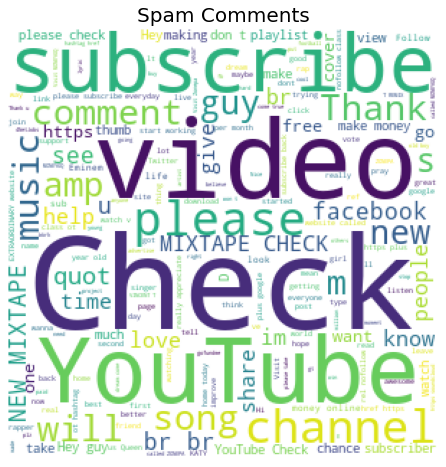

In [14]:
display_wordcloud(X_train[y_train == 1], 'Spam Comments')

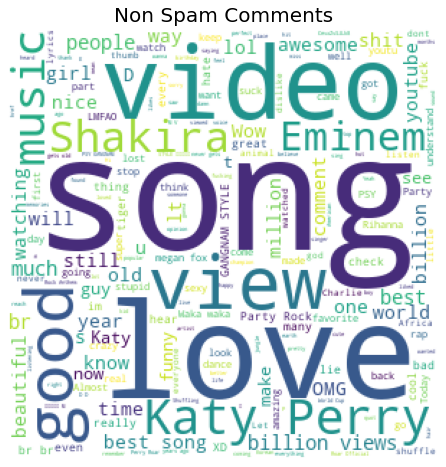

In [15]:
display_wordcloud(X_train[y_train == 0], 'Non Spam Comments')

From the wordclouds above, we can see that words like 'url', 'video', 'subscribe', 'check', 'please', 'YouTube' are common in the Spam comments and words like 'love', 'happy', 'song', 'view' are common in Non Spam comments. As we can see, the word 'video' is commonly occurring in both kind of comments and can be added in our set of stop words.

**Let's look at the top 10 common words of both Spam and Non Spam comments to see if there are any more tokens that are frequently occuring in both**

In [16]:
def get_common_words(data, n):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(data[COLUMN_CONTENT])
    vocabulary = vectorizer.get_feature_names()
    ind = np.argsort(X.toarray().sum(axis=0))[-n:]
    top_n_words = [vocabulary[a] for a in ind]

    return top_n_words

In [17]:
common_spam = get_common_words(X_train[y_train == 1], 10)
print('Top 20 Common Words in Spam Comments \n', common_spam)

Top 20 Common Words in Spam Comments 
 ['just', 'like', 'br', 'channel', '39', 'video', 'subscribe', 'youtube', 'com', 'check']


In [18]:
common_non_spam = get_common_words(X_train[y_train == 0], 10)
print('Top 20 Common Words in Non Spam Comments \n', common_non_spam)

Top 20 Common Words in Non Spam Comments 
 ['39', 'billion', 'best', 'br', 'katy', 'video', 'views', 'like', 'love', 'song']


In [19]:
print(set(common_non_spam).intersection(set(common_spam)))

{'like', 'video', '39', 'br'}


**Analysis:**

It looks like the words 'br', 'video', 'like' occur frequently in both Spam and non Spam comments. These words can be added as Stop words. Also, '39' is frequently occuring because the term '&#39' which is an HTML entity code for the apostrophe, this can be replaced by an actual apostrophe.

**Let's see the distribution of character count of the comments in the data.**

In [20]:
# Function to analyze the distribution of character count of comments
def analyze_character_count(train_data):
    character_data = [len(x) for x in train_data[COLUMN_CONTENT]]

    plt.hist(character_data)
    plt.ylabel('Number of Comments')
    plt.xlabel('Count of Characters')
    plt.title('Distribution of Character Count of Comments')
    plt.show()

    return character_data

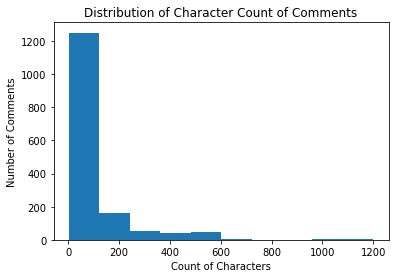

Average character count of the comments: 95.4079283887468


In [21]:
character_data = analyze_character_count(X_train)
average_length = np.mean(character_data)
print('Average character count of the comments:', average_length)

In [22]:
y_train[X_train[COLUMN_CONTENT].apply(
    lambda x: len(x)
) > average_length].value_counts()

1    311
0     86
Name: CLASS, dtype: int64

**Analysis:**

It looks like more Spam comments have a character count higher than the average character count compared to non spam comments. It looks like 'Character Count' is a good indicator of Spam and Non Spam which can be added as an additional feature.

In [23]:
# Function to analyze the distribution of token count of comments
def analyze_token_count(train):
    token_data = pd.Series([len(x.split(' ')) for x in train[COLUMN_CONTENT]])

    plt.hist(token_data)
    plt.ylabel('Number of comments')
    plt.xlabel('Count of Tokens')
    plt.title('Distribution of Number of Tokens in Comments')
    plt.show()

    return token_data

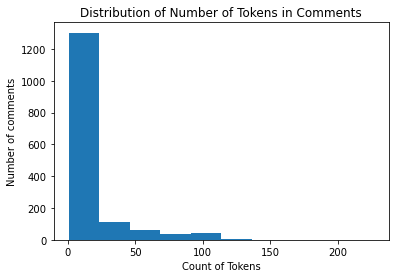

Average token count of the data: 16.34846547314578


In [24]:
token_data = analyze_token_count(X_train)
average_length = np.mean(token_data)
print('Average token count of the data:', average_length)

In [25]:
y_train[X_train[COLUMN_CONTENT].apply(
    lambda x: len(x)
) > average_length].value_counts()

1    793
0    583
Name: CLASS, dtype: int64

**Analysis**

The distribution looks comparatively balanced in this case.

### Data Cleaning

Data Cleaning is a very crucial step when we are working with text data. We are applying the following steps to clean our data before Feature Extraction :

1) Remove HTML Tags
2) Replace URLs with 'url' token
3) Remove extra white space
4) Remove characters with encoding like '\ufeff'
5) Replace emojis with 'emoji' token
6) Replace emoticons with their actual description tag
7) Replace numeric digits
8) Remove punctuations

In [26]:
# Replace urls with 'url' token and replace '&#39' in the data
def replace_url(comments, replacement_word):
    comments = str(comments)
    comments = re.sub(HTTP_URL_PATTERN, replacement_word, comments)
    comments = re.sub(URL_PATTERN, replacement_word, comments)
    comments = re.sub(HTML_APOSTROPHE_PATTERN, "'", comments)
    return comments

In [27]:
# Remove extra white space
def remove_extra_spaces(comments):
    comments = re.sub('\s+', ' ', comments)
    return comments

In [28]:
# Remove characters with encoding like \ufeff (The first 128 Unicode code point values are the same as ASCII)
def remove_encoding(text):
    return ''.join(i for i in text if ord(i) < 128)

In [29]:
# Replace emojis with 'emoji' token
def replace_emojis(s):
    return ''.join(
        '<emoji>' if c in emoji.UNICODE_EMOJI['en']
        else c for c in s
    )

In [30]:
# Replace emoticons with their actual description tag using ekphrasis package
def replace_emoticons(s):
    tokens = s.split(' ')
    for i, token in enumerate(tokens):
        if token in emoticons:
            tokens[i] = emoticons[token]
    return ' '.join(tokens)

In [31]:
def preprocess(data):

    # Remove HTML tags
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: bs4.BeautifulSoup(x, 'lxml').get_text()
    )

    # Other Preprocessing
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: replace_url(x, 'url')
    )
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: remove_extra_spaces(x)
    )
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: remove_encoding(x)
    )
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: replace_emojis(x)
    )
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: replace_emoticons(x)
    )

    # Remove numeric digits
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: re.sub(NUMERIC_PATTERN, '', x)
    )

    # Remove punctuations
    punctuations_to_remove = set(string.punctuation)
    data[COLUMN_CONTENT] = data[COLUMN_CONTENT].apply(
        lambda x: re.sub('[%s]' % re.escape(''.join(punctuations_to_remove)), '', x)
    )

    return data

In [32]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

**Here is how our data looks like after cleaning**

In [33]:
X_train[COLUMN_CONTENT].to_list()[:10]

['if url in  subscribe to SuperMarioLogan ',
 'LIKE AND SUBSCRIB IF YOU WATCH IN  wink',
 'Hey come check us out were new on youtube let us know what you think and dont forget to subscribe thanks',
 'LADIES  If you have a broken heart or you just want to understand guys better you should check out this underground book called The Power of the Pussy on AMAZON Best book ever for us girls Ohand just a warning its for  and overlol',
 'best song eva',
 'Love this song',
 'Nice love itttttttt wurkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk',
 'subscribe me plzzzzzzz plzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
 'Party rock',
 'Check the shit out on my channelSUBSCRIBE YOU WILL LIKE IT']

### Feature Engineering

In [34]:
# Creating a new feature 'Character Count' based on our EDA

# X_train['CHAR_COUNT'] = [len(x) for x in X_train[COLUMN_CONTENT]]
# X_test['CHAR_COUNT'] = [len(x) for x in X_test[COLUMN_CONTENT]]

### Feature Extraction

For our machine learning model to understand our text based feature, we need to convert it to numeric based features. I have tried two methods as part of feature extraction from text data -> Count Vectorizer and TF-IDF Vectorizer.

1) Count Vectorizer : Convert a collection of text documents to a matrix of token counts. Parameters tried : `lowercase`, `min_df` and `stop_words`

2) TF-IDF Vectorizer : It is used to quantify the importance or relevance of string representations (words, phrases, lemmas, etc) in a document amongst a collection of documents. Parameters tried : `stop_words` and `lowercase`

In [35]:
# Creating stop words set and adding words that are common in both Spam and Non Spam Comments
edited_stop_words = set(stopwords.words('english'))
edited_stop_words.add('video')
edited_stop_words.add('like')
edited_stop_words.add('br')

In [36]:
# Segregating features
text_features = COLUMN_CONTENT
# numeric_features = ['CHAR_COUNT']

Based on results on the validation set, the feature 'CHAR_COUNT' didn't perform as expected and we will be commenting it for our current solution.

In [37]:
# Building a Count Vectorizer
# preprocessor = make_column_transformer(
#     (CountVectorizer(
#         stop_words=edited_stop_words,
#         lowercase=True,
#         min_df=2
#     ), text_features),
#     (StandardScaler(),
#      numeric_features)
# )

In [38]:
# naivebayes_preprocessor = make_column_transformer(
#     (CountVectorizer(
#         stop_words=edited_stop_words,
#         lowercase=True,
#         min_df=2
#     ), text_features),
#     (MinMaxScaler(),
#      numeric_features)
# )

In [39]:
# Building a TF-IDF Vectorizer
preprocessor = make_column_transformer(
    (TfidfVectorizer(
        stop_words=edited_stop_words,
        lowercase=True
    ), text_features)
)

In [40]:
naivebayes_preprocessor = make_column_transformer(
    (TfidfVectorizer(
        stop_words=edited_stop_words,
        lowercase=True
    ),text_features)
)

In [41]:
transformed_data = preprocessor.fit_transform(X_train, y_train)
transformed_data.shape

(1564, 3071)

### Model Building

In [42]:
results = {}

We are using the approach of Cross Validation of evaluate the model performance of multiple models and compare them 

In [43]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    '''
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    '''

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append(('%0.3f (+/- %0.3f)' % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

**Scoring Metrics**

Since, this is a balanced classification problem with almost comparable distribution of both the class labels, Accuracy can be considered as an evaluation metric. However, even though the class distribution is balanced both the class labels are not equally important. In the given problem statement of YouTube comments classification our main aim would be to minimize the amount of False Positives (Type I error) as a spam filter for youtube comments should not filter out the real comment. In this case, False Positives are comments that are actually 'non-spam' (Label 0) but are predicted as 'spam' (Label 1). **Precision** would be a more desirable metric as it tells how many of the correctly predicted cases actually turned out to be positive. Precision is useful in the cases where False Positive is a higher concern than False Negatives. Hence, i think we can consider both *Accuracy* and *Precision* to evaluate the overall model performance for the given problem.

In [44]:
# Defining the scoring metrics
scoring = ['accuracy', 'precision']

In [45]:
# Building Dummy Classifier as Baseline
dummy_classifier_pipeline = make_pipeline(preprocessor, DummyClassifier())

results['Dummy Classifier'] = mean_std_cross_val_scores(
    dummy_classifier_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True
)

In [46]:
# Building Logistic Regression
logistic_regression_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=2000)
)

results['Logistic Regression'] = mean_std_cross_val_scores(
    logistic_regression_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True
)

In [47]:
# Building Naive Bayes
naive_bayes_pipeline = make_pipeline(naivebayes_preprocessor, MultinomialNB())

results['Naive Bayes'] = mean_std_cross_val_scores(
    naive_bayes_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True
)

In [48]:
# Building Random Forest Classifier
random_forest_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier()
)

results['Random Forest'] = mean_std_cross_val_scores(
    random_forest_pipeline,
    X_train,
    y_train,
    scoring=scoring,
    return_train_score=True
)

In [49]:
# Analysis of Model Training
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Naive Bayes,Random Forest
fit_time,0.017 (+/- 0.008),0.030 (+/- 0.013),0.016 (+/- 0.006),0.225 (+/- 0.017)
score_time,0.004 (+/- 0.001),0.004 (+/- 0.001),0.004 (+/- 0.001),0.015 (+/- 0.000)
test_accuracy,0.514 (+/- 0.001),0.937 (+/- 0.012),0.877 (+/- 0.012),0.942 (+/- 0.015)
train_accuracy,0.514 (+/- 0.000),0.960 (+/- 0.001),0.959 (+/- 0.003),0.998 (+/- 0.001)
test_precision,0.514 (+/- 0.001),0.966 (+/- 0.014),0.848 (+/- 0.025),0.968 (+/- 0.024)
train_precision,0.514 (+/- 0.000),0.984 (+/- 0.001),0.949 (+/- 0.004),0.998 (+/- 0.001)


### Hyperparameter Optimization

Hyperparameter optimization is the process of selecting the values for a model’s hyperparameters that maximize the accuracy of the model. Based on the results we have got above, it looks like *Logistic Regression* Classifier and *Random Forest* Classifier are performing the best. So, we can try optimizing them further.

In [50]:
models = [
    ('Random Forest', random_forest_pipeline),
    ('Logistic Regression', logistic_regression_pipeline)
]

index = [model[0] for model in models]

# Parameter grid for hyperparameter optimization
param_grid = {
    'Logistic Regression': {
        'logisticregression__C': np.arange(2, 7.5, 0.25),
        'logisticregression__solver': [
            'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
        ],
        'logisticregression__random_state': [0]
    },
    'Random Forest': {
        'randomforestclassifier__n_estimators': [200, 250, 300, 350],
        'randomforestclassifier__max_depth': [45, 50, 55, 60, 70],
        'randomforestclassifier__criterion': ['gini', 'entropy']
    }
}

# Storing best results in a dataframe
optimized_results = pd.DataFrame(
    columns=['Selected Hyperparameters', 'Accuracy'],
    index=index
)

# Storing cv_results in a dataframe for further analysis
cv_results = {}

# Performing grid-search hyperparameter optimization to optimize results
for i, model in enumerate(models):
    grid_search = GridSearchCV(
        model[1],
        param_grid=param_grid[model[0]],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    optimized_results.loc[model[0], 'Selected Hyperparameters'] = [
        grid_search.best_params_
    ]

    optimized_results.loc[model[0], 'Accuracy'] = grid_search.best_score_

    cv_results[model[0]] = grid_search.cv_results_

In [51]:
# Random Forest Analysis
pd.DataFrame(cv_results['Random Forest'])[
    [
        'rank_test_score',
        'mean_test_score',
        'mean_train_score',
        'param_randomforestclassifier__n_estimators',
        'param_randomforestclassifier__max_depth',
        'param_randomforestclassifier__criterion'
    ]
].set_index('rank_test_score').sort_index().T

rank_test_score,1,2,3,4,5,6,6,8,9,10,...,30,32,33,34,35,36,37,37,39,40
mean_test_score,0.9431,0.942461,0.941822,0.941185,0.941183,0.941181,0.941181,0.940542,0.94054,0.939905,...,0.937343,0.936708,0.936704,0.936069,0.936067,0.936063,0.93543,0.93543,0.934148,0.934146
mean_train_score,0.984815,0.985454,0.988811,0.981138,0.981618,0.983376,0.983056,0.983856,0.988331,0.983057,...,0.980339,0.986893,0.985614,0.97922,0.981618,0.97986,0.985294,0.980819,0.97938,0.97986
param_randomforestclassifier__n_estimators,300,350,300,250,250,200,300,200,200,350,...,350,350,250,200,200,350,200,300,250,200
param_randomforestclassifier__max_depth,60,60,70,50,55,60,55,55,70,55,...,55,70,70,50,50,45,60,55,50,45
param_randomforestclassifier__criterion,gini,gini,gini,gini,entropy,entropy,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,gini,gini,gini,entropy,entropy,gini


In [52]:
# Logistic Regression Analysis
pd.DataFrame(cv_results['Logistic Regression'])[
    [
        'rank_test_score',
        'mean_test_score',
        'mean_train_score',
        'param_logisticregression__C',
        'param_logisticregression__random_state',
        'param_logisticregression__solver'
    ]
].set_index('rank_test_score').sort_index().T

rank_test_score,1,1,1,1,1,1,1,1,1,1,...,79,79,79,79,79,79,79,79,109,110
mean_test_score,0.940542,0.940542,0.940542,0.940542,0.940542,0.940542,0.940542,0.940542,0.940542,0.940542,...,0.938623,0.938623,0.938623,0.938623,0.938623,0.938623,0.938623,0.938623,0.937984,0.937343
mean_train_score,0.993286,0.992647,0.992647,0.992647,0.992327,0.992647,0.993126,0.993126,0.992327,0.993126,...,0.98961,0.988811,0.988811,0.990569,0.990569,0.990569,0.988811,0.988811,0.980179,0.976982
param_logisticregression__C,6.75,6.0,6.25,6.25,5.75,6.25,6.5,6.5,5.75,6.5,...,3.75,3.5,3.5,4.5,4.5,4.5,3.5,3.5,2.25,2.0
param_logisticregression__random_state,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
param_logisticregression__solver,newton-cg,sag,newton-cg,lbfgs,sag,sag,newton-cg,lbfgs,lbfgs,sag,...,newton-cg,lbfgs,newton-cg,sag,liblinear,lbfgs,sag,liblinear,saga,saga


In [53]:
optimized_results

,Selected Hyperparameters,Accuracy
Random Forest,"[{'randomforestclassifier__criterion': 'gini',...",0.9431
Logistic Regression,"[{'logisticregression__C': 5.75, 'logisticregr...",0.940542


In [54]:
optimized_results["Selected Hyperparameters"]["Random Forest"][0]

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 60,
 'randomforestclassifier__n_estimators': 300}

**Analysis:**

As we can see from the results of our hyperparameter optimization, it looks like the Accuracy of Logistic Regression and Random Forest has improved compared to the default values of the hyperparameters. Since, Random Forest seems to perform slightly better we will using it to generate our predictions.

### Results

In [55]:
rf_best_params = optimized_results["Selected Hyperparameters"]["Random Forest"][0]

tuned_random_forest_pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        criterion=rf_best_params['randomforestclassifier__criterion'],
        max_depth=rf_best_params['randomforestclassifier__max_depth'],
        n_estimators=rf_best_params['randomforestclassifier__n_estimators'],
    )
)

In [56]:
tuned_random_forest_pipeline.fit(X_train, y_train)

predictions = tuned_random_forest_pipeline.predict(X_test)

predictions = pd.DataFrame(
    predictions,
    columns=['Predicted'],
    index=X_test.index
)

print('The accuracy of the model based on the test set: {}'.format(
    accuracy_score(y_test, predictions)
))

print('The precision of the model based on the test set: {}'.format(
    precision_score(y_test, predictions)
))

The accuracy of the model based on the test set: 0.9438775510204082
The precision of the model based on the test set: 0.9837837837837838


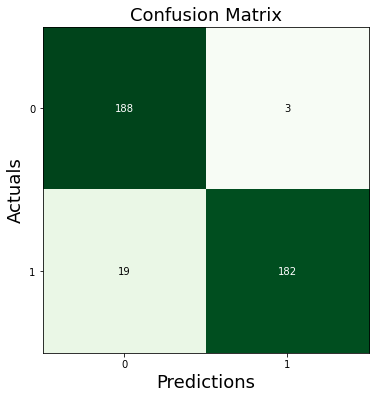

In [57]:
c = confusion_matrix(y_test, predictions)
fig, ax = plot_confusion_matrix(conf_mat=c, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [58]:
result_dataframe = pd.concat(
    [X_test[COLUMN_CONTENT], y_test, predictions],
    axis=1,
    ignore_index=True
)

result_dataframe.columns = ['Comments', 'True Class', 'Predicted Class']

In [59]:
result_dataframe

,Comments,True Class,Predicted Class
5,The best world cup song ever,0,0
398,Check out this video on YouTubeLooking for my ...,1,1
314,Hey guys ready for more Cyphers back check ou...,1,1
106,great song you go katy,0,0
305,if u love rihanna subscribe me,1,1
...,...,...,...
207,Is that tiger called Katty Purry,0,0
145,Wow,0,0
356,CHECK OUT THIS NEW VIDEO I MADE CALLED WE LOVE...,1,1
198,and more,0,0


**Results**

Based on the results on the test set, the model is able to predict around **98.3%** (Precision) positive (spam) examples and around **94.3%** total test examples correctly.